In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import cv2
import os
import gc
import warnings

from sklearn.model_selection import train_test_split
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
from keras import layers

warnings.filterwarnings('ignore')


In [3]:
# Class labels (folder names)
classes = ['lung_aca', 'lung_n', 'lung_scc']

# Path to your Google Drive dataset
path = '/content/drive/MyDrive/lung_cancer'

# Model hyperparameters
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64


In [4]:
for cat in classes:
    image_dir = os.path.join(path, cat)
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Sample images for category: {cat}', fontsize=20)

    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(os.path.join(image_dir, images[k])))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [5]:
X = []
Y = []

for i, cat in enumerate(classes):
    images = glob(f'{path}/{cat}/*.jpeg')  # adjust to .png if needed
    for image in images:
        img = cv2.imread(image)
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            X.append(img)
            Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y, test_size=SPLIT, random_state=2022)


In [6]:
model = keras.models.Sequential([
    layers.Conv2D(32, (5, 5), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3), padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    33,554,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,684,291 (128.50 MB)

 Trainable params: 33,683,523 (128.49 MB)

 Non-trainable params: 768 (3.00 KB)

In [8]:
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

# Custom callback class
class myCallback(Callback):  # ✅ Fix: use 'Callback' not 'tf.keras.callbacks.Callback'
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') > 0.90:
            print('\nValidation accuracy reached 90%, stopping training.')
            self.model.stop_training = True

# Early stopping and LR scheduler
es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)



In [10]:
# 1. Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 2. Train the model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[es, lr, myCallback()]  # <- custom and standard callbacks
)



Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 690s 12s/step - accuracy: 0.7530 - loss: 0.6209 - val_accuracy: 0.6422 - val_loss: 4.8668 - learning_rate: 0.0010
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 695s 11s/step - accuracy: 0.8459 - loss: 0.3572 - val_accuracy: 0.3267 - val_loss: 7.1136 - learning_rate: 0.0010
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.8938 - loss: 0.2512 
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
57/57 ━━━━━━━━━━━━━━━━━━━━ 717s 12s/step - accuracy: 0.8939 - loss: 0.2509 - val_accuracy: 0.3267 - val_loss: 8.3444 - learning_rate: 0.0010
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 641s 11s/step - accuracy: 0.9347 - loss: 0.1720 - val_accuracy: 0.6956 - val_loss: 0.6434 - learning_rate: 5.0000e-04
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 721s 12s/step - accuracy: 0.9631 - loss: 0.1057 - val_accuracy: 0.6600 - val_loss: 1.4015 - learning_rate: 5.0000e-04
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9775 - loss: 0.074

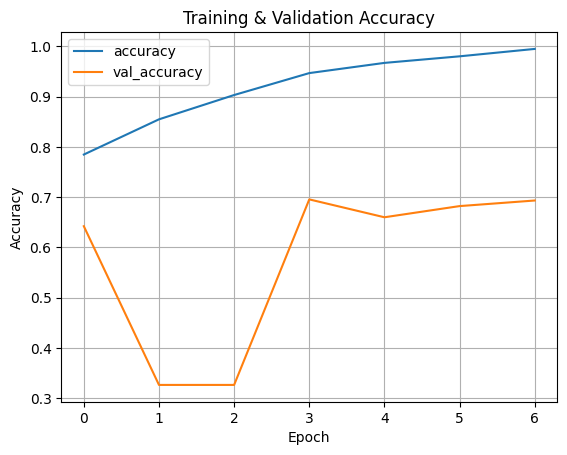

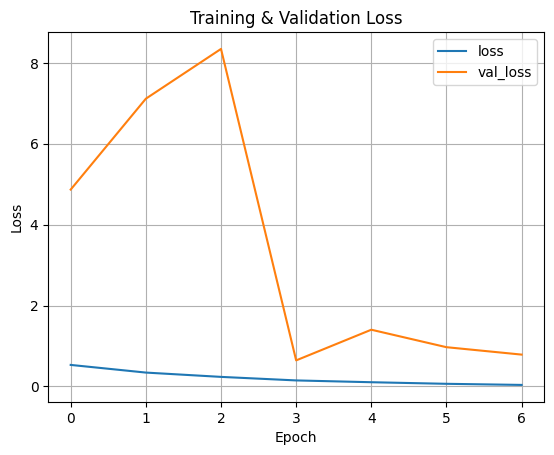

In [11]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

history_df.loc[:, ['loss', 'val_loss']].plot()
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [12]:
Y_pred = model.predict(X_val)
Y_val_class = np.argmax(Y_val, axis=1)
Y_pred_class = np.argmax(Y_pred, axis=1)

print(metrics.classification_report(Y_val_class, Y_pred_class, target_names=classes))


29/29 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step
              precision    recall  f1-score   support

    lung_aca       0.53      0.99      0.69       311
      lung_n       0.99      0.95      0.97       294
    lung_scc       1.00      0.13      0.23       295

    accuracy                           0.70       900
   macro avg       0.84      0.69      0.63       900
weighted avg       0.83      0.70      0.63       900

